# CNN-lytical Assignment-4
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image segmentation.

* Segmentation is the task of classifying pixels into classes - whether those pixels are a part of a certain object or not.

* The model we will be using is UNet, you can read about it here - https://arxiv.org/pdf/1505.04597.pdf

* Much of what you learnt in Assignments 2 and 3 will carry over to this assignment. The structure would overall remain the same - a Dataset class, a Model class and a Training loop. However, significant effort would go into creating these because UNet is a complex model in itself.

* **No processing of the data should happen outside the Dataset class, which should take in raw inputs directly from the unpickled object**.

* Because this would be the first time you deal with a complex model, feel free to refer to this video - https://www.youtube.com/watch?v=u1loyDCoGbE - Abhishek Thakur (one of the top Kaggle GMs) walks you through the design of the model and how you can make subclasses to make your code clean and reusable.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [1]:
import numpy
import torch
import random
import pickle
import os
import torchvision
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
device='cpu'
if torch.cuda.is_available():
    device='cuda'
print(device)
# device='cpu'
#import torchvision
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(42)

cuda


## Load *Dataset*
Use the [pickle file](https://drive.google.com/file/d/1EiCGYDhztVLBPmpS2_SsFgfrWPDtsDsk/view?usp=sharing) shared for this assignment here.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load the data set
with open('/content/drive/MyDrive/train_carvana.pkl','rb') as f:
    data=pickle.load(f)
X = data['X']
y = data['y']
del data
print(y.dtype)
print(X.shape,y.shape)
# Split into X_train, y_train, X_val, y_val
# you can use stratified splitting from sklearn library
X=[X[:50],X[50:]]
y=[y[:50],y[50:]]



float32
(80, 1280, 1918, 3) (80, 1280, 1918)


In the following cell, display one data-point in each line, with three images - the original image, the segmentation mask and the two of them superposed over each other.

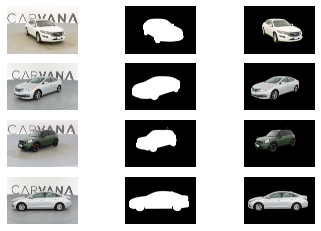

In [4]:
# display 4 datapoints as described above 
for i in range(4):
    idx=random.randrange(0,80)
    pyplot.subplot(4,3,3*i+1)
    pyplot.imshow(X[idx//X[0].shape[0]][idx%X[0].shape[0]])
    pyplot.axis('off')
    pyplot.subplot(4,3,3*i+2)
    pyplot.imshow(y[idx//X[0].shape[0]][idx%X[0].shape[0]],cmap='gray')
    pyplot.axis('off')
    pyplot.subplot(4,3,3*i+3)
    pyplot.imshow(X[idx//X[0].shape[0]][idx%X[0].shape[0]]*y[idx//X[0].shape[0]][idx%X[0].shape[0]].reshape(1280,1918,1))
    pyplot.axis('off')
pyplot.show()

## Creating a Dataset Class
Create a Dataset class like in the previous assignment. However, this time you **should** perform augmentation.

**Note -** While initializing the dataset class object, make sure you only pass the numpy arrays for images and masks. So the ```__init__``` function should look like
```
    def __init__(self, X, y):
```

In [5]:
# define your dataset class
myAugmentation=torchvision.transforms.Compose([
    T.ConvertImageDtype(torch.uint8),
    T.RandomInvert(p=0.2),
    T.RandomPosterize(3,p=0.2),
    T.RandomEqualize(p=0.2),
    T.ConvertImageDtype(torch.float)
])
# Alternative augmentation function(Random)
auto_augmenter = T.RandAugment()
class data(torch.utils.data.Dataset):
    def __init__(self,X,y):
        self.y=y
        self.X=X
    def __len__(self):
        return self.y.shape[0]
    def __getitem__(self,idx):
        image=self.X[idx]
        label=self.y[idx]
        image=T.functional.to_tensor(image)
        label=torch.from_numpy(label)
        if random.random()<0:
            image=T.functional_tensor.hflip(image)
            label=T.functional_tensor.hflip(label)
        if random.random()<0:
            image=T.functional_tensor.vflip(image)
            label=T.functional_tensor.vflip(label)
        image=myAugmentation(image)
        # To see the augmentation in images, uncomment the following lines
        #   ----   ----   ----   ----   ----   ----   ----   ----   ----   ----   #
        # pyplot.subplot(1,3,1)
        # pyplot.imshow(image.permute(1,2,0).numpy())
        # pyplot.subplot(1,3,2)
        # pyplot.imshow(label.numpy().reshape(1280,1918,1),cmap='gray')
        # pyplot.subplot(1,3,3)
        # pyplot.imshow(image.permute(1,2,0).numpy()*label.numpy().reshape(1280,1918,1))
        # pyplot.show()
        #   ----   ----   ----   ----   ----   ----   ----   ----   ----   ----   #
        return (image,label)


class predict_data(torch.utils.data.Dataset):
    def __init__(self,X):
        self.X=X
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self,idx):
        image=T.functional.to_tensor(self.X[idx])
        return image

In [6]:
def double_conv(ch_in,ch_out):
    conv=torch.nn.Sequential(torch.nn.Conv2d(ch_in,ch_out,3,padding=1),
                             torch.nn.ReLU(inplace=True),
                             torch.nn.Conv2d(ch_out,ch_out,3,padding=1),
                             torch.nn.BatchNorm2d(ch_out),
                             torch.nn.ReLU(inplace=True)
                            )
    return conv

In [7]:
# define a child class of nn.Module for your model
# specify the architecture here itself
# if necessary, make submodules in different cells for structured code
class UNetModel1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # input image=(3,1280,1918)
        self.relu=torch.nn.ReLU()
        self.pad1=torch.nn.ZeroPad2d((1,1,0,0))
        self.pad2=torch.nn.ZeroPad2d((0,0,1,1))
        self.pool=torch.nn.MaxPool2d(2,2)
        self.conv1=double_conv(3,32) # (3,1276,1914)
        # pooling will give 32,638,957
        self.conv2=double_conv(32,64)
        # pooling, resulting image=64,317,476
        self.conv3=double_conv(64,128)
        # resulting image=128,313,472
        self.conv4=double_conv(128,256)
        self.up_conv1=torch.nn.ConvTranspose2d(256,128,2,stride=2)
        self.conv5=double_conv(256,128)
        self.conv6=double_conv(128,64)
        self.up_conv2=torch.nn.ConvTranspose2d(128,64,2,stride=2)
        self.up_conv3=torch.nn.ConvTranspose2d(64,32,2,stride=2)
        self.conv7=double_conv(64,32)
        self.final_conv=torch.nn.Conv2d(32,1,3)
    def forward(self,image):
        # image= (3,1280,1918)
        image=image.to(device)
        image=self.pad1(image)
        x1=self.conv1(image) # (32,1280,1920)
        x2=self.conv2(self.pool(x1)) # (64,640,960)
        x3=self.conv3(self.pool(x2)) # (128,320,480)
        x=self.conv4(self.pool(x3)) # (128,320,480)
        x=self.up_conv1(x)
        x=torch.cat((x3,x),1) # (128,640,960)
        x=self.conv5(x) # (64,640,960)
        x=torch.cat((x2,self.up_conv2(x)),1) # (64,1280,1920)
        x=self.conv6(x) # (32,1280,1920)
        x=torch.cat((x1,self.up_conv3(x)),1) # (64,1280,1920)
        x=self.conv7(x) # (32,1280,1920)
        x=self.pad2(x) # (32,1282,1920)
        x=self.final_conv(x) # (2,1280,1918)
        x=self.relu(x)
        return x


In [8]:
class UNetModel2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # input image=(3,1280,1918)
        self.relu=torch.nn.ReLU()
        self.pad1=torch.nn.ZeroPad2d((1,1,0,0))
        self.pad2=torch.nn.ZeroPad2d((0,0,1,1))
        self.pool=torch.nn.MaxPool2d(2,2)
        self.conv1=double_conv(3,32) # (3,1276,1914)
        # pooling will give 32,638,957
        self.conv2=double_conv(32,64)
        # pooling, resulting image=64,317,476
        self.conv3=double_conv(64,128)
        # resulting image=128,313,472
        self.up_conv1=torch.nn.ConvTranspose2d(128,64,2,stride=2)
        self.conv4=double_conv(128,64)
        self.conv5=double_conv(64,32)
        self.up_conv2=torch.nn.ConvTranspose2d(64,32,2,stride=2)
        self.final_conv=torch.nn.Conv2d(32,1,3)
    def forward(self,image):
        # image= (3,1280,1918)
        image=image.to(device)
        image=self.pad1(image)
        x1=self.conv1(image) # (32,1280,1920)
        x2=self.conv2(self.pool(x1)) # (64,640,960)
        x=self.conv3(self.pool(x2)) # (128,320,480)
        x=self.up_conv1(x)
        x=torch.cat((x2,x),1) # (128,640,960)
        x2=0
        x=self.conv4(x) # (64,640,960)
        x=torch.cat((x1,self.up_conv2(x)),1) # (64,1280,1920)
        x1=0
        x=self.conv5(x) # (32,1280,1920)
        x=self.pad2(x) # (32,1282,1920)
        x=self.final_conv(x) # (2,1280,1918)
        x=self.relu(x)
        return x


## Training loop
As in the previous assignments, you will write a training loop here. Learning from past experience, do maintain a validation set and monitor loss/accuracy on that to save the best model (instead of having to interrupt execution).

In [9]:
def train(model, optimizer, criterion, train_loader, val_loader, display_step=None):
    i=0
    for epoch in range(10):
        for img,lbl in train_loader:
            i+=1
            # to show augmented img
            # pyplot.subplot(3,1,1)
            # pyplot.imshow(img[0].reshape([1280,1918,3]))
            # pyplot.subplot(3,1,2)
            # pyplot.imshow(lbl[0].reshape([1280,1918,1]),cmap='gray')
            # pyplot.subplot(3,1,3)
            # pyplot.imshow(img[0].reshape([1280,1918,3])*(lbl[0].reshape([1280,1918,1])))
            # training start
            optimizer.zero_grad()
            lbl=lbl[None,:,:,:]
            # print(img.shape,lbl.shape)
            # dtyp=T.ConvertImageDtype(torch.uint8)
            # lbl=dtyp(lbl)
            lbl=lbl.to(device)
            outputs=model.forward(img)
            loss=criterion(outputs,lbl)
            loss.to(device)
            loss.backward()
            optimizer.step()
            if(display_step):
                if((i-1)%display_step==0):
                    print('Epoch:',epoch+1,'Iteration:',i,'Loss:',loss.item())
            del outputs
            del loss
        # not working as expected.. :(
        # num=0
        # denom=0
        # for x,y in val_loader:
        #     y=y.to(device)
        #     num+=(model.forward(x)==y).sum()
        #     denom+=numpy.ones(y.shape).sum()
        # print(f'After {epoch+1} epochs, accuracy for validation dataset is computed as: {num/denom*100}')

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [10]:
def init_weights():
    pass

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**, the mask you predict.

The accuracy function would be the number of pixels you get a correct mask for.

In [11]:
def predict(model, X_test):
    # return model.forward(torch.from_numpy(X_test.reshape([(X_test.shape)[0],3,1280,1918])))
    dataset=predict_data(X_test)
    images=torch.from_numpy(X_test)
    dataloader=torch.utils.data.DataLoader(dataset)
    output=numpy.zeros([X_test.shape[0],1280,1918])
    i=0
    for x in dataloader:
        output[i]=model.forward(x).to('cpu').detach().numpy()[0][0]
        i+=1
    numpy.array(output)
    output/=output.max()
    output=numpy.round_(output)
    return output

In [12]:
def accuracy(pred, labels):
    print(labels.shape,pred.shape)
    return ((pred==labels).sum())/(labels.shape[0]*labels.shape[1]*labels.shape[2]) * 100

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [13]:
dataset_train=data(X[0],y[0])
dataloader_train=torch.utils.data.DataLoader(dataset_train,batch_size=1,shuffle=True)
dataset_test=data(X[1],y[1])
dataloader_test=torch.utils.data.DataLoader(dataset_test,batch_size=1,shuffle=True)
model=UNetModel2()
model.to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.0002)
criterion=torch.nn.SoftMarginLoss()
train(model,optimizer,criterion,dataloader_train,dataloader_test,display_step=30)

Epoch: 1 Iteration: 1 Loss: 0.6886481642723083
Epoch: 1 Iteration: 31 Loss: 0.5636191964149475
Epoch: 2 Iteration: 61 Loss: 0.5890842080116272
Epoch: 2 Iteration: 91 Loss: 0.5712623596191406
Epoch: 3 Iteration: 121 Loss: 0.5665093660354614
Epoch: 4 Iteration: 151 Loss: 0.5375082492828369
Epoch: 4 Iteration: 181 Loss: 0.5433483123779297
Epoch: 5 Iteration: 211 Loss: 0.5787156224250793
Epoch: 5 Iteration: 241 Loss: 0.5296611189842224
Epoch: 6 Iteration: 271 Loss: 0.5612786412239075
Epoch: 7 Iteration: 301 Loss: 0.6020733714103699
Epoch: 7 Iteration: 331 Loss: 0.5333136916160583
Epoch: 8 Iteration: 361 Loss: 0.5694189071655273
Epoch: 8 Iteration: 391 Loss: 0.5803928971290588
Epoch: 9 Iteration: 421 Loss: 0.564325749874115
Epoch: 10 Iteration: 451 Loss: 0.5300011038780212
Epoch: 10 Iteration: 481 Loss: 0.5535972714424133


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [14]:
prediction=predict(model,X[1])
print(f'Accuracy for test set is: {accuracy(prediction,y[1])}.')

(30, 1280, 1918) (30, 1280, 1918)
Accuracy for test set is: 87.89637371828294.


This task is not like the usual classification task, you also need to check how the model is doing visually to appreciate the level of learning. Visualize 10 outputs below (as you did in the visualization cell near the top of the notebook).

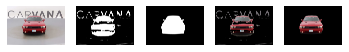

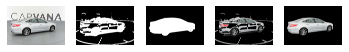

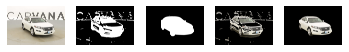

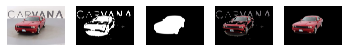

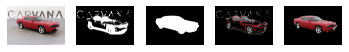

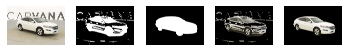

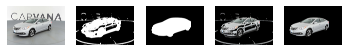

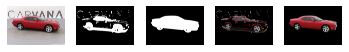

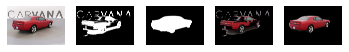

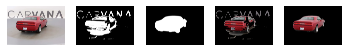

In [15]:
for i in range(10):
    idx=random.randrange(0,X[1].shape[0])
    pyplot.subplot(1,5,1)
    pyplot.imshow(X[1][idx])
    pyplot.axis('off')
    pyplot.subplot(1,5,2)
    pyplot.imshow(prediction[idx],cmap='gray')
    pyplot.axis('off')
    pyplot.subplot(1,5,4)
    pyplot.imshow(X[1][idx]*(prediction[idx].reshape(1280,1918,1)))
    pyplot.axis('off')
    pyplot.subplot(1,5,3)
    pyplot.imshow(y[1][idx],cmap='gray')
    pyplot.axis('off')
    pyplot.subplot(1,5,5)
    pyplot.imshow(X[1][idx]*(y[1][idx].reshape(1280,1918,1)))
    pyplot.axis('off')
    pyplot.show()

## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file ```dataset.py``` with the dataset class and all necessary imports. Other than this, save the trained model in a file named ```ass_4.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py```, ```dataset.py``` class files and the ```ass_4.pt``` model-weights file to the repository.

Note that if you use submodules, all of them should go into the `model.py` file.

In [16]:
# torch.save(model, 'ass_4.pt')

Check if it got saved right!

In [17]:
# freeing RAM for further actions
import gc
# dir()
del(prediction)
del(dataloader_train)
del(dataloader_test)
del(data)
del(criterion)
# del(optimizer)
del(X)
del(y)
# del(model)
del(dataset_train)
del(dataset_test)
gc.collect(generation=2)

29554

In [18]:
# dir()

(80, 1280, 1918) (80, 1280, 1918)
Accuracy: 89.71456676876956


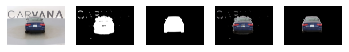

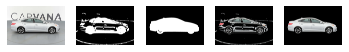

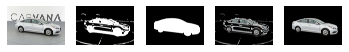

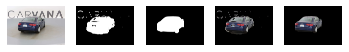

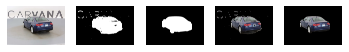

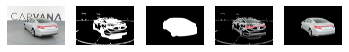

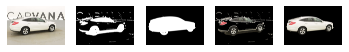

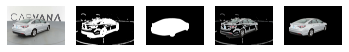

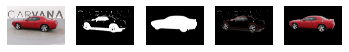

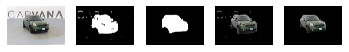

In [19]:
# load the model, use predict function
# model=torch.load('ass_4.pt').to(device)
with open('/content/drive/MyDrive/train_carvana.pkl','rb') as f:
    data=pickle.load(f)
X = data['X']
y = data['y']
del data
prediction=predict(model,X)
print('Accuracy:', accuracy(prediction,y))
for i in range(10):
    idx=random.randrange(0,X.shape[0])
    pyplot.subplot(1,5,1)
    pyplot.imshow(X[idx])
    pyplot.axis('off')
    pyplot.subplot(1,5,2)
    pyplot.imshow(prediction[idx],cmap='gray')
    pyplot.axis('off')
    pyplot.subplot(1,5,4)
    pyplot.imshow(X[idx]*(prediction[idx].reshape(1280,1918,1)))
    pyplot.axis('off')
    pyplot.subplot(1,5,3)
    pyplot.imshow(y[idx],cmap='gray')
    pyplot.axis('off')
    pyplot.subplot(1,5,5)
    pyplot.imshow(X[idx]*(y[idx].reshape(1280,1918,1)))
    pyplot.axis('off')
    pyplot.show()
del prediction
del X
del y